<a href="https://colab.research.google.com/github/anderm18/CurlingVAR/blob/main/CurlingDataloader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Curling Dataloader

The huge next step to this process is creating a Dataloader for the curling data we've been working with. In short, a dataloader is a PyTorch object that allows us to quickly batch and serve our data for a model, which makes training, testing, and validating not only easier but more performant. The goals here are to load all the images into a class which can properly apply any transforms to the images (herein referred to as the X) and target transforms to the annotations we're comparing to (herein referred to as the Y).

First, let's make a raw train, test, split function that we can use. We want to accomplish a 70% training set, %15 test set, and %15 validation set for these splits. The reason for validation is to give our model a dataset to compare to after training and testing that the model has never seen before to prevent overfitting.

In [24]:
import os
import torch
import pandas as pd
from google.colab import drive
from matplotlib import pyplot as plt
from torchvision.io import read_image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from PIL import Image

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/My Drive/achilles2022_out/meta.csv')

In [5]:
df

,filename,filepath,empty
0,0.jpg,images/0.jpg,0
1,1.jpg,images/1.jpg,1
2,2.jpg,images/2.jpg,1
3,3.jpg,images/3.jpg,1
4,4.jpg,images/4.jpg,1
...,...,...,...
1865,1865.jpg,images/1865.jpg,0
1866,1866.jpg,images/1866.jpg,0
1867,1867.jpg,images/1867.jpg,1
1868,1868.jpg,images/1868.jpg,0


In [6]:
def split(dataframe):
  train, test = train_test_split(dataframe, train_size=.70, stratify=df['empty'])
  test, validate = train_test_split(test, train_size=.50, stratify=test['empty'])
  return train, test, validate

In [7]:
train, test, validate = split(df)

In [8]:
print("Length of Training Set:", len(train))
print("Length of Test Set:", len(test))
print("Length of Validation Set:", len(validate))

Length of Training Set: 1309
Length of Test Set: 280
Length of Validation Set: 281


In [9]:
print("Empty in Training Set:", len(train[train['empty'] == 1]))
print("Full in Training Set:", len(train[train['empty'] == 0]))
print("Empty in Test Set:", len(test[test['empty'] == 1]))
print("Full in Test Set:", len(test[test['empty'] == 0]))
print("Empty in Validation Set:", len(validate[validate['empty'] == 1]))
print("Full in Validation Set:", len(validate[validate['empty'] == 0]))

Empty in Training Set: 861
Full in Training Set: 448
Empty in Test Set: 184
Full in Test Set: 96
Empty in Validation Set: 185
Full in Validation Set: 96


Looks like that worked well, now we can move on to the Dataloader itself:

In [29]:
class CurlingDataset(Dataset):

  _train = None
  _test = None
  _validate = None

  def __init__(self, csv_loc, img_dir, set_type="train", transform=None, target_transform=None):
    self.data = pd.read_csv(csv_loc)
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform


    if type(CurlingDataset._train) == type(None):
      print("Performing a split")
      CurlingDataset._train, CurlingDataset._test, CurlingDataset._validate = self.__split()

    self.data = CurlingDataset._train if set_type == "train" else (CurlingDataset._test if set_type == "test" else CurlingDataset._validate)

  def __len__(self):
    return len(self.data)

  def __split(self):

    train, test = train_test_split(self.data, train_size=.70, stratify=df['empty'])
    test, validate = train_test_split(test, train_size=.50, stratify=test['empty'])

    return train, test, validate

  def __getitem__(self, index):

    img_path = os.path.join(self.img_dir, self.data.iloc[index, 1])

    image = read_image(img_path)
    label = torch.tensor(int(self.data.iloc[index, 2]))

    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

In [30]:
train_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="train",
    transform=transforms.Resize((512, 512))
)

test_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="test",
    transform=transforms.Resize((512, 512))
)

validate_data = CurlingDataset(
    "/content/drive/My Drive/achilles2022_out/meta.csv",
    "/content/drive/My Drive/achilles2022_out/",
    set_type="validate",
    transform=transforms.Resize((512, 512))
)

Performing a split


In [31]:
train_dataloader = DataLoader(train_data, batch_size=32)
test_dataloader = DataLoader(test_data, batch_size=32)
validate_dataloader = DataLoader(validate_data, batch_size=32)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


X Batch Shape: torch.Size([32, 3, 512, 512])
Y Batch Label: torch.Size([32])


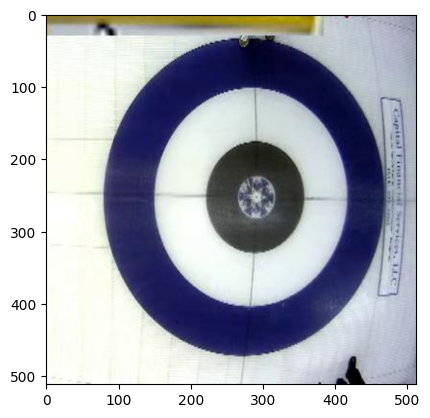

In [32]:
train_feature, train_label = next(iter(train_dataloader))
print("X Batch Shape:", train_feature.size())
print("Y Batch Label:", train_label.size())
img = train_feature[0].squeeze()
label = train_label[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()